In [23]:
using Revise

In [24]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [25]:
using Blink

In [26]:
robot = BoxAtlas(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 6835`, ProcessRunning), TCPSocket(RawFD(78) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(4, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(83) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 4, Nullable{Any}(true))))

In [27]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 32, 32, 1]; regularization=1e-3)
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [28]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
#         copy!(x0, x_init)
#         set_velocity!(x0, findjoint(x0.mechanism, "floating_base"),
#             [σv * (2 * (rand() - 0.5)), 0.0, 0.0])
        LearningMPC.randomize!(x0, x_init, 0.0, σv)
        Δv = zeros(num_velocities(x0))
        Δv[1] = σv * (2 * rand() - 0.5)
        set_velocity!(x0, velocity(x0) .+ Δv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 25, 
            params.lcp_solver;
            termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
        append!(data, sink.samples)
    end
end

(::#55) (generic function with 1 method)

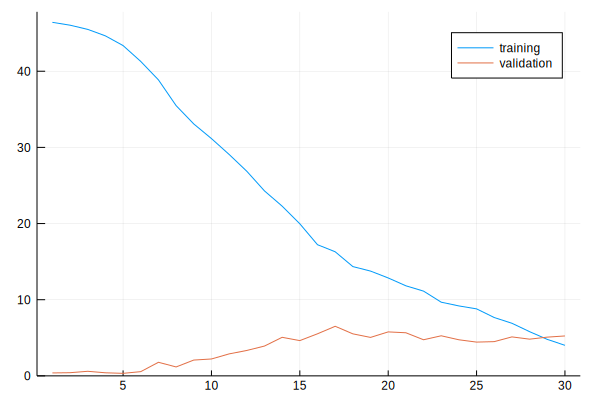

  2.087284 seconds (4.57 M allocations: 547.445 MiB, 12.14% gc time)


Progress:   0%|                                         |  ETA: 21:30:02

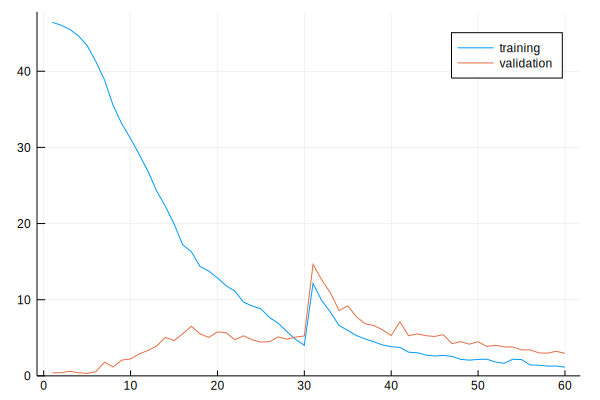

  3.197373 seconds (9.11 M allocations: 1.067 GiB, 10.02% gc time)


Progress:   1%|                                         |  ETA: 21:56:01

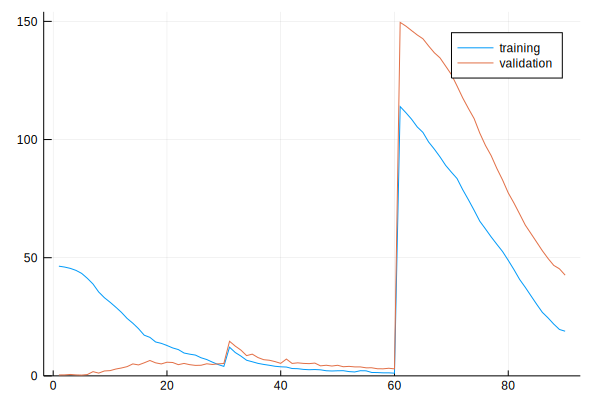

  5.216084 seconds (13.57 M allocations: 1.588 GiB, 15.23% gc time)


Progress:   2%|█                                        |  ETA: 20:58:19

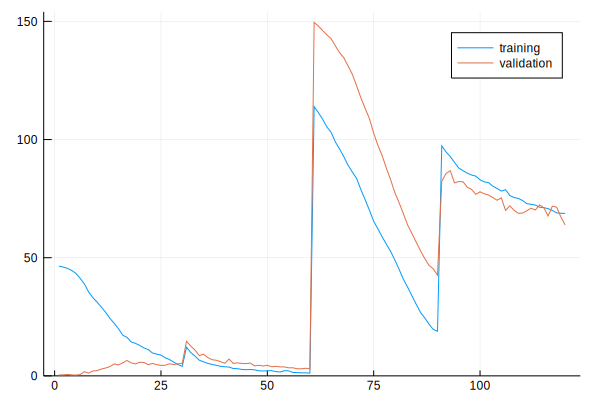

  6.557596 seconds (17.04 M allocations: 1.997 GiB, 17.45% gc time)


Progress:   2%|█                                        |  ETA: 20:18:40

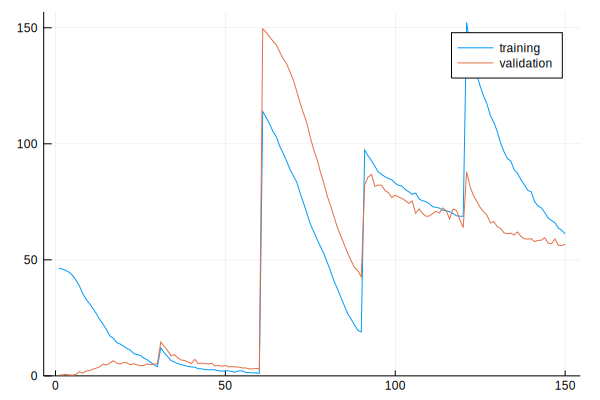

  7.157520 seconds (19.30 M allocations: 2.259 GiB, 15.26% gc time)


Progress:   2%|█                                        |  ETA: 18:01:15

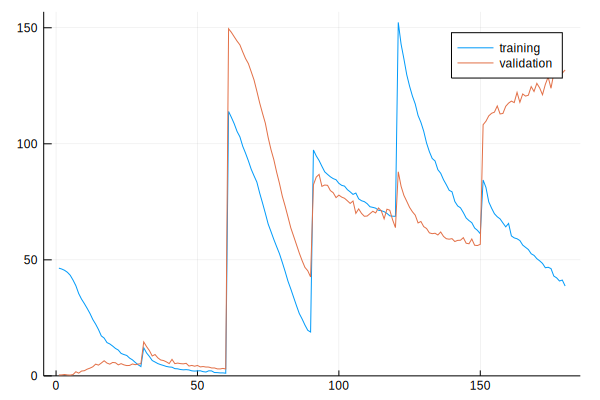

  8.353808 seconds (22.31 M allocations: 2.615 GiB, 12.99% gc time)


Progress:   3%|█                                        |  ETA: 17:43:43

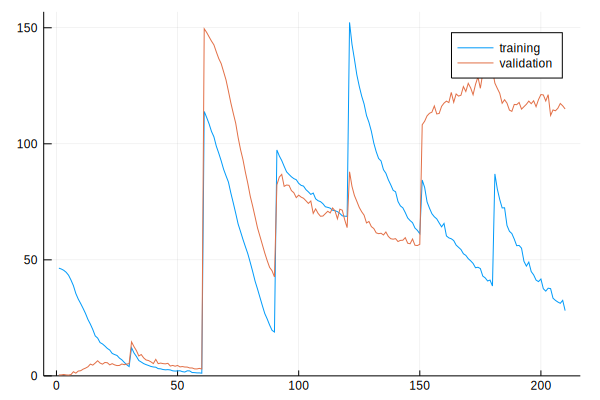

  9.649407 seconds (25.08 M allocations: 2.937 GiB, 15.33% gc time)


Progress:   4%|█                                        |  ETA: 16:45:36

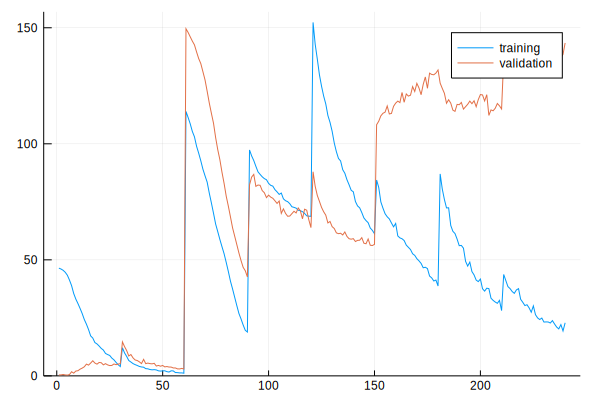

 10.040173 seconds (27.95 M allocations: 3.273 GiB, 11.99% gc time)


Progress:   4%|██                                       |  ETA: 16:15:57

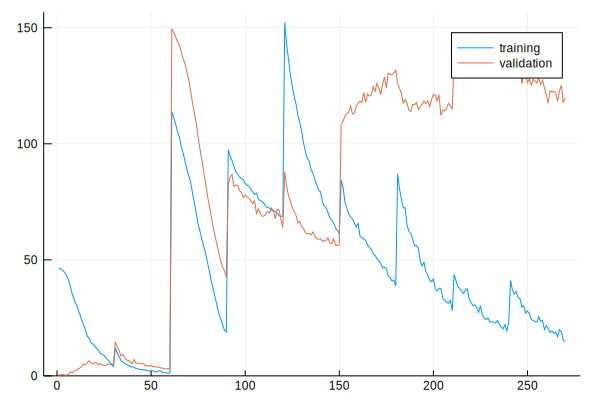

 11.334937 seconds (31.75 M allocations: 3.714 GiB, 11.17% gc time)


Progress:   4%|██                                       |  ETA: 16:09:07

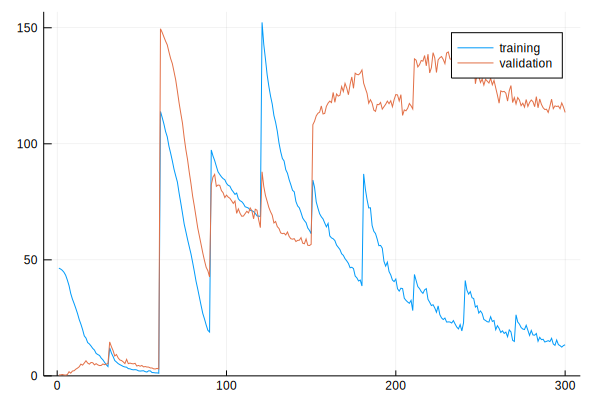

 12.066636 seconds (34.64 M allocations: 4.053 GiB, 12.25% gc time)


Progress:   5%|██                                       |  ETA: 15:53:17

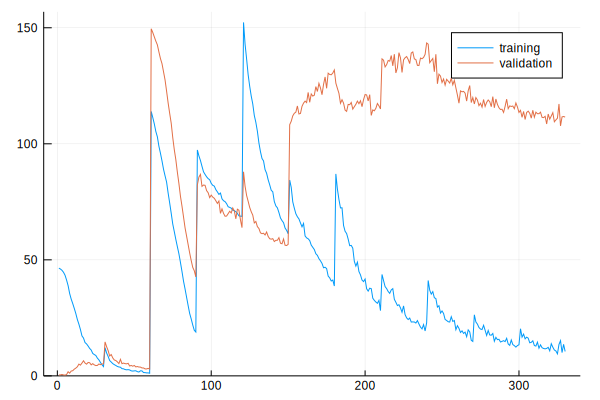

 14.350238 seconds (37.24 M allocations: 4.361 GiB, 13.54% gc time)


Progress:   6%|██                                       |  ETA: 15:40:57

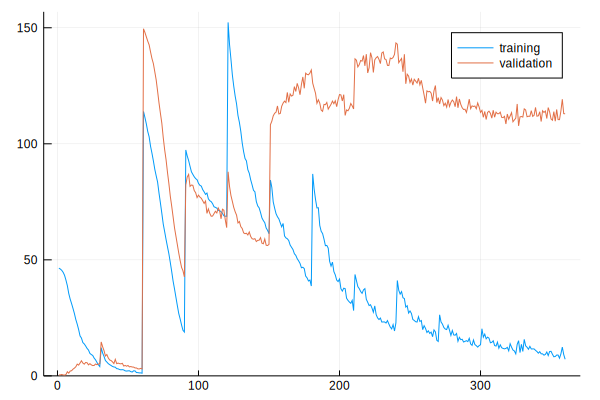

 13.862504 seconds (40.48 M allocations: 4.744 GiB, 10.04% gc time)


Progress:   6%|██                                       |  ETA: 15:43:17

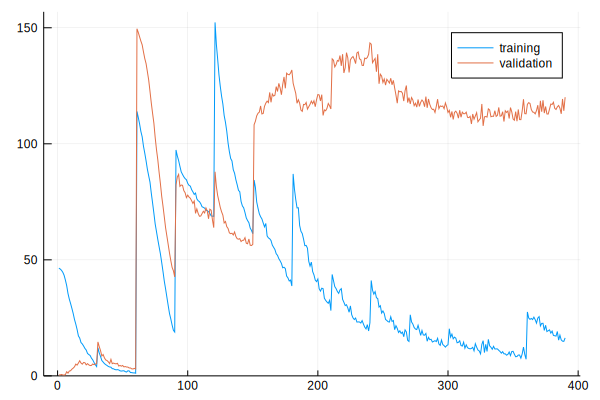

 14.485847 seconds (42.81 M allocations: 5.015 GiB, 10.25% gc time)


Progress:   6%|███                                      |  ETA: 15:10:12

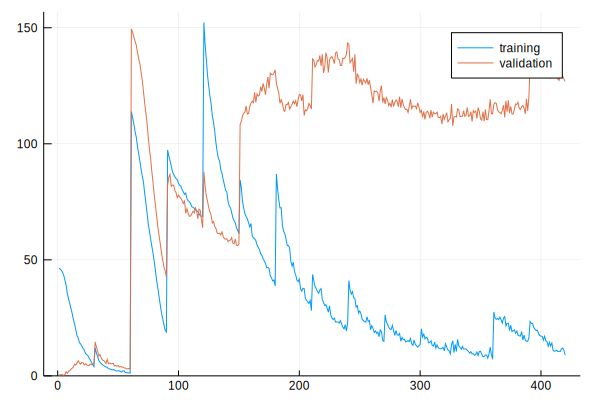

 15.844198 seconds (46.06 M allocations: 5.397 GiB, 11.83% gc time)


Progress:   7%|███                                      |  ETA: 15:09:36

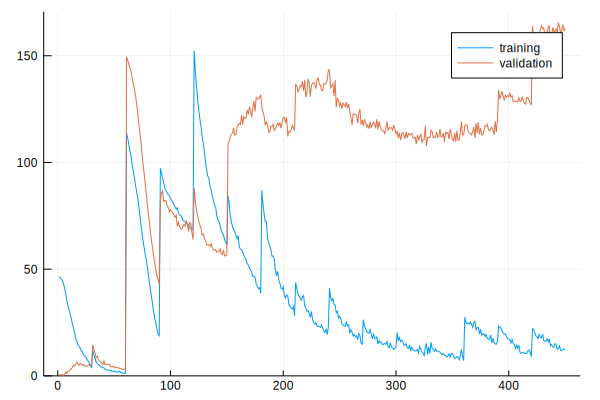

 17.280507 seconds (48.87 M allocations: 5.727 GiB, 12.73% gc time)


Progress:   8%|███                                      |  ETA: 14:54:02

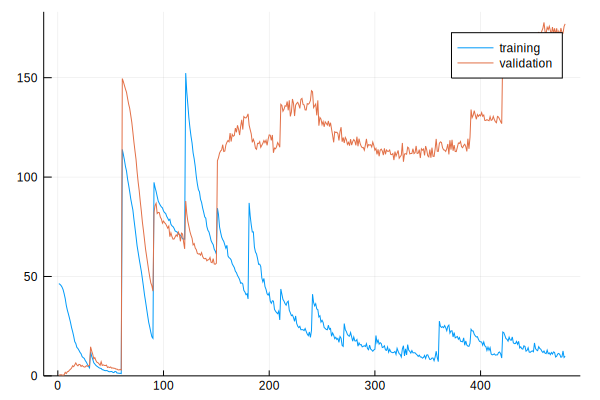

 18.485822 seconds (50.61 M allocations: 5.932 GiB, 12.32% gc time)


Progress:   8%|███                                      |  ETA: 14:28:39

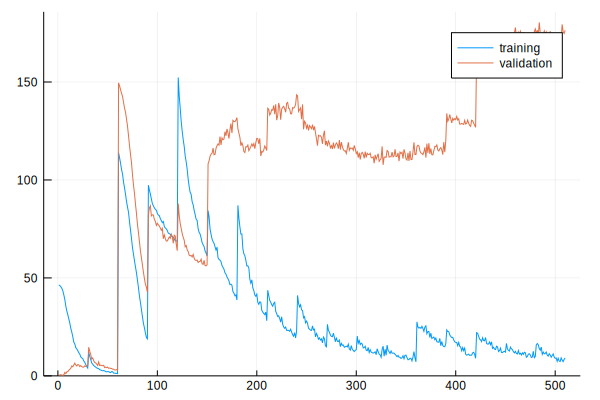

 18.277036 seconds (52.87 M allocations: 6.194 GiB, 12.41% gc time)


Progress:   8%|███                                      |  ETA: 14:05:39

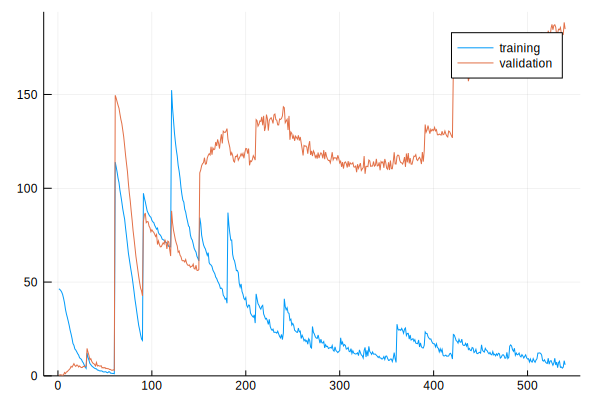

 19.041343 seconds (56.17 M allocations: 6.579 GiB, 11.34% gc time)


Progress:   9%|████                                     |  ETA: 13:59:29

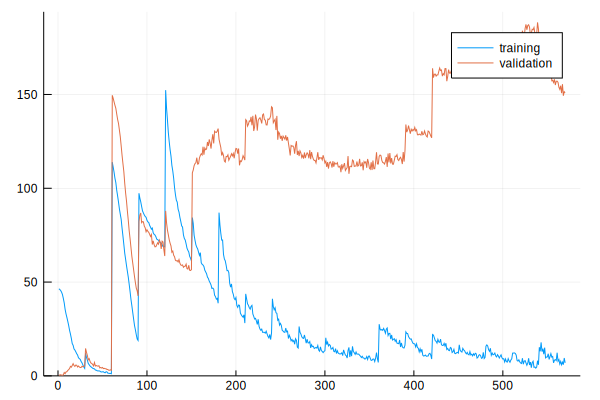

 20.234689 seconds (59.16 M allocations: 6.932 GiB, 11.50% gc time)


Progress:  10%|████                                     |  ETA: 13:58:12

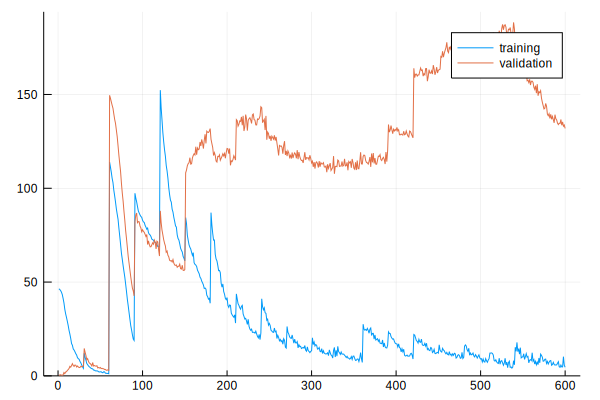

 21.818304 seconds (62.06 M allocations: 7.268 GiB, 12.13% gc time)


Progress:  10%|████                                     |  ETA: 13:46:42

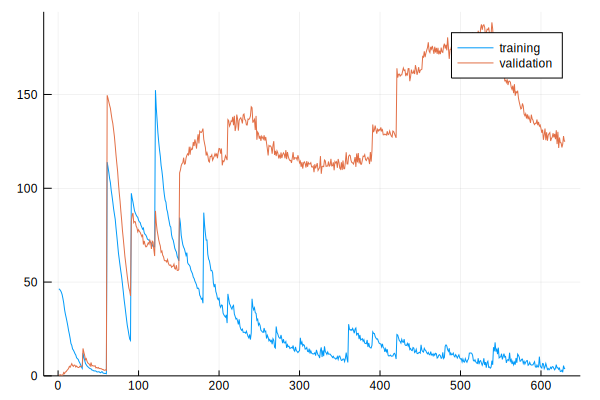

 22.216917 seconds (63.11 M allocations: 7.391 GiB, 11.75% gc time)


Progress:  10%|████                                     |  ETA: 13:19:57

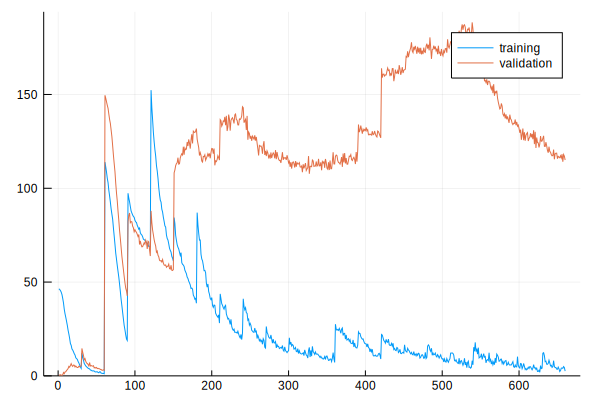

 22.929034 seconds (67.24 M allocations: 7.871 GiB, 11.43% gc time)


Progress:  11%|█████                                    |  ETA: 13:23:34

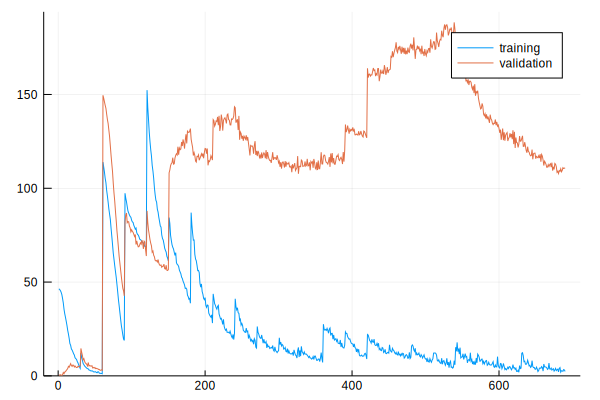

 24.133192 seconds (70.08 M allocations: 8.204 GiB, 12.07% gc time)


Progress:  12%|█████                                    |  ETA: 13:20:58

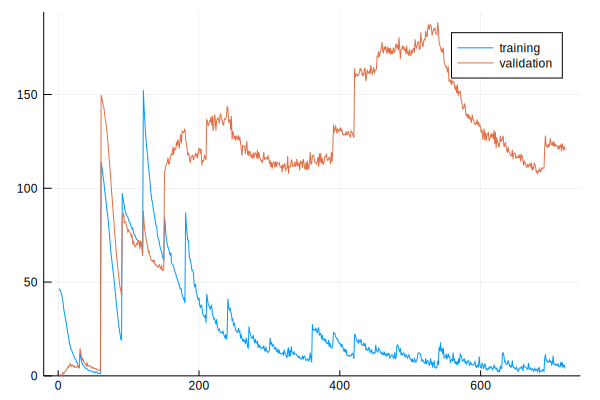

 26.603439 seconds (73.44 M allocations: 8.595 GiB, 14.56% gc time)


Progress:  12%|█████                                    |  ETA: 13:18:03

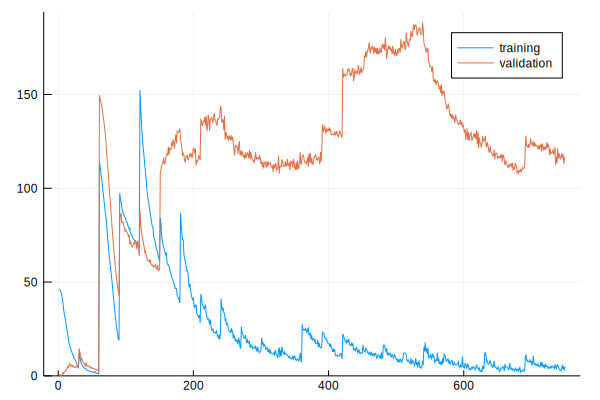

 25.804825 seconds (74.41 M allocations: 8.709 GiB, 11.32% gc time)


Progress:  12%|█████                                    |  ETA: 12:53:25

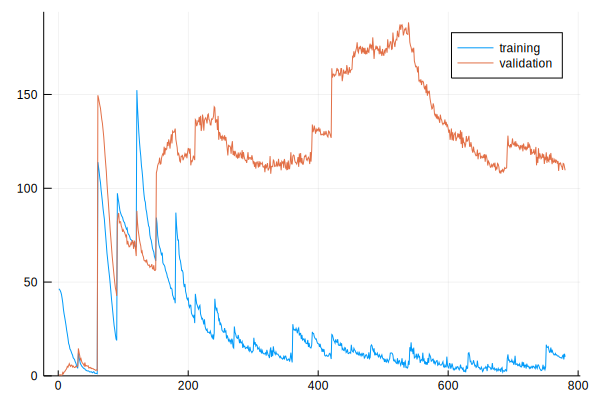

 27.184769 seconds (76.96 M allocations: 9.012 GiB, 11.42% gc time)


Progress:  13%|█████                                    |  ETA: 12:50:10

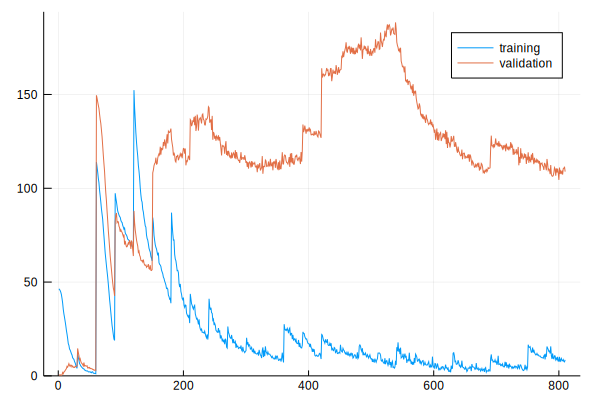

 27.747963 seconds (80.71 M allocations: 9.446 GiB, 10.84% gc time)


Progress:  14%|██████                                   |  ETA: 12:48:06

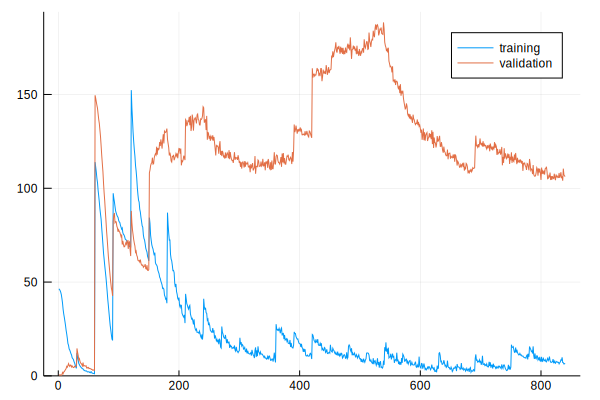

 29.335889 seconds (83.03 M allocations: 9.722 GiB, 11.29% gc time)


Progress:  14%|██████                                   |  ETA: 12:43:36

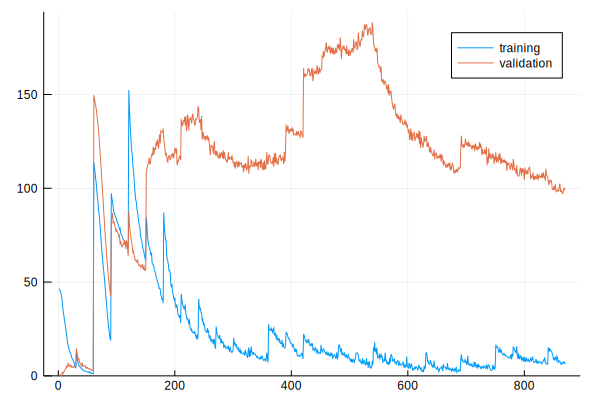

 30.125201 seconds (87.16 M allocations: 10.201 GiB, 11.37% gc time)


Progress:  14%|██████                                   |  ETA: 12:44:39

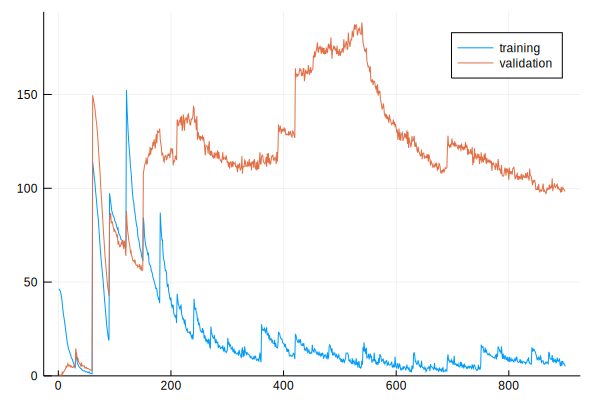

 30.920457 seconds (91.36 M allocations: 10.690 GiB, 11.07% gc time)


Progress:  15%|██████                                   |  ETA: 12:48:56

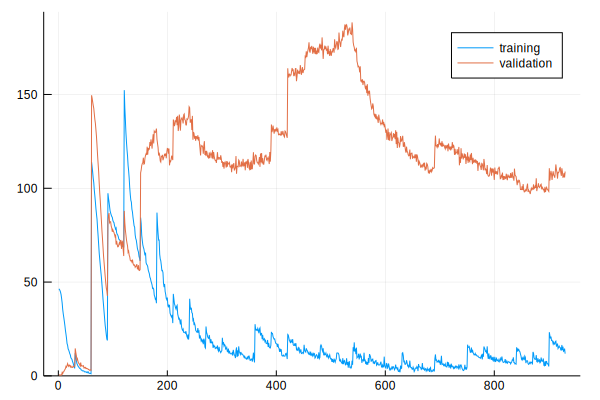

 32.456662 seconds (94.44 M allocations: 11.049 GiB, 11.23% gc time)


Progress:  16%|██████                                   |  ETA: 12:45:22

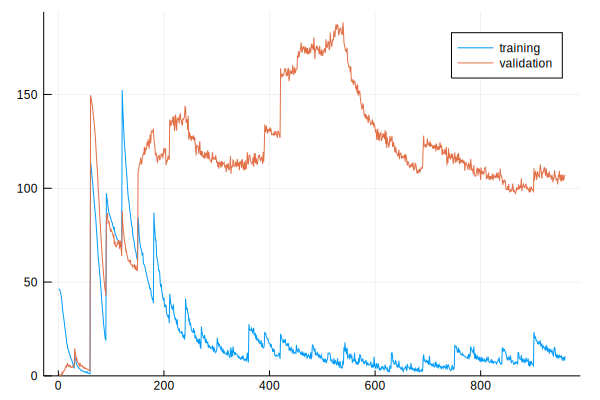

 32.568310 seconds (96.08 M allocations: 11.240 GiB, 11.08% gc time)


Progress:  16%|███████                                  |  ETA: 12:29:18

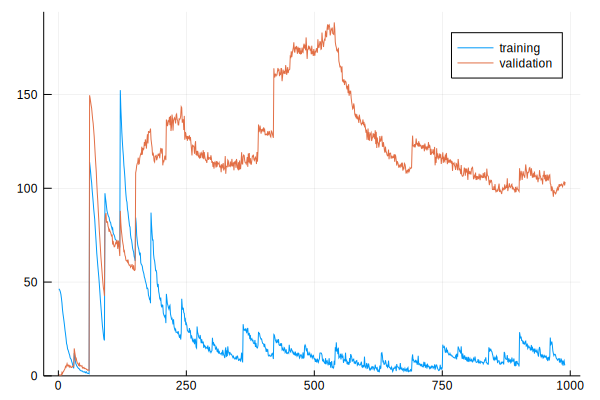

 36.064096 seconds (99.38 M allocations: 11.626 GiB, 12.77% gc time)


Progress:  16%|███████                                  |  ETA: 12:28:07

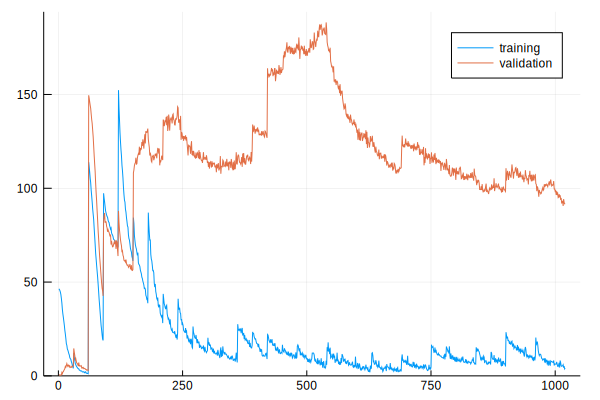

 37.895210 seconds (101.87 M allocations: 11.915 GiB, 14.53% gc time)


Progress:  17%|███████                                  |  ETA: 12:19:58

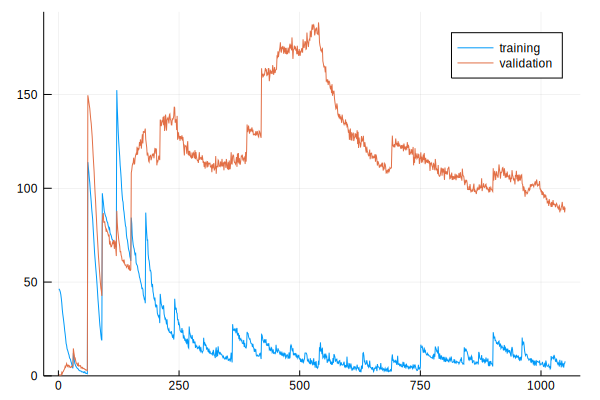

 38.512595 seconds (105.18 M allocations: 12.300 GiB, 14.36% gc time)


Progress:  18%|███████                                  |  ETA: 12:18:22

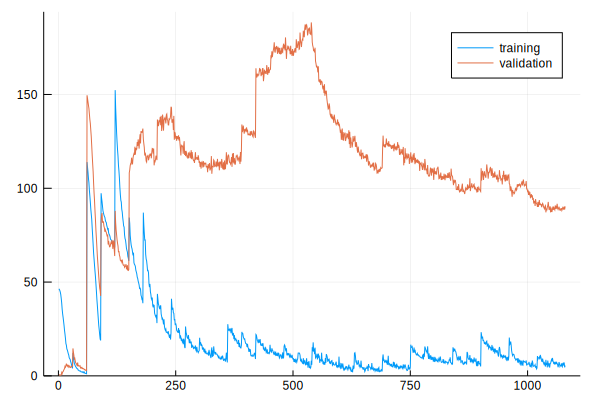

 38.601518 seconds (108.22 M allocations: 12.659 GiB, 11.29% gc time)


Progress:  18%|███████                                  |  ETA: 12:18:37

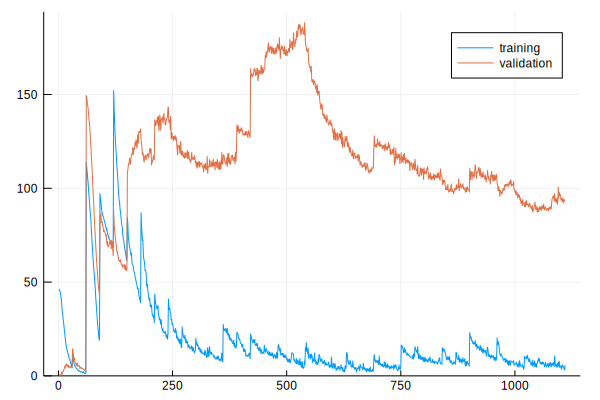

 39.401348 seconds (111.69 M allocations: 13.068 GiB, 13.60% gc time)


Progress:  18%|████████                                 |  ETA: 12:19:49

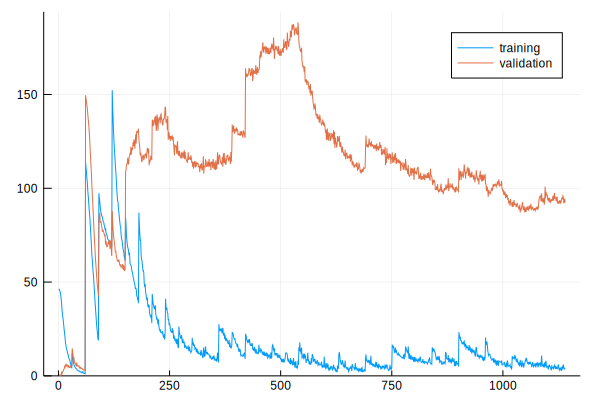

 38.081291 seconds (113.09 M allocations: 13.236 GiB, 10.70% gc time)


Progress:  19%|████████                                 |  ETA: 12:09:50

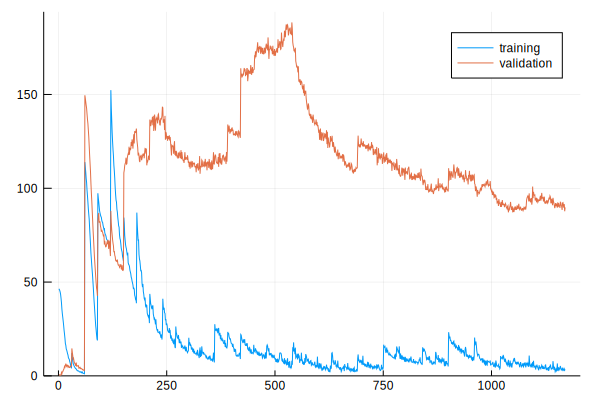

 42.193292 seconds (116.38 M allocations: 13.624 GiB, 14.08% gc time)


Progress:  20%|████████                                 |  ETA: 12:10:57

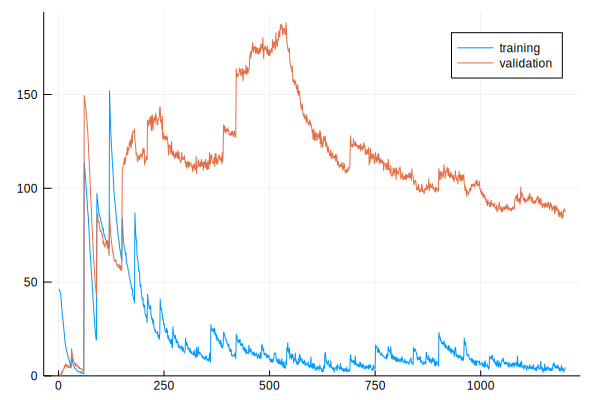

 40.519478 seconds (118.92 M allocations: 13.919 GiB, 11.30% gc time)


Progress:  20%|████████                                 |  ETA: 12:03:18

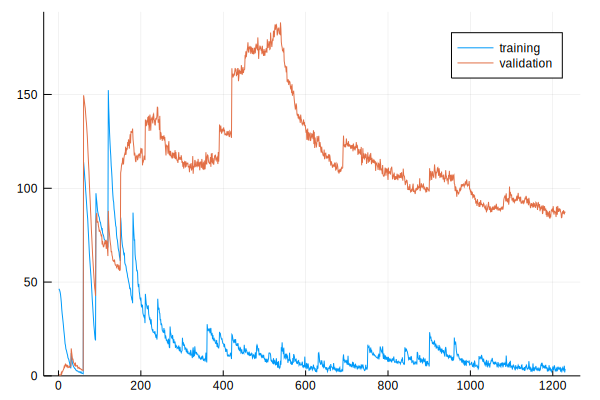

 40.696084 seconds (121.02 M allocations: 14.166 GiB, 10.53% gc time)


Progress:  20%|████████                                 |  ETA: 11:55:43

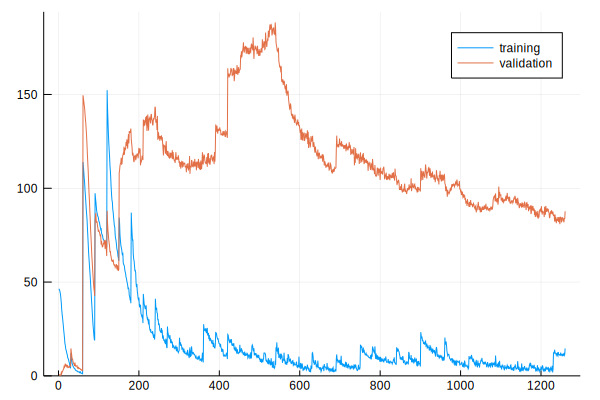

 42.609700 seconds (124.49 M allocations: 14.575 GiB, 10.21% gc time)


Progress:  21%|█████████                                |  ETA: 11:56:41

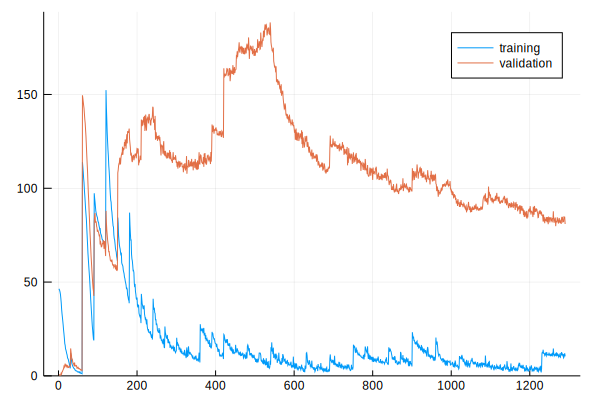

 43.820602 seconds (127.27 M allocations: 14.904 GiB, 10.40% gc time)


Progress:  22%|█████████                                |  ETA: 11:55:10

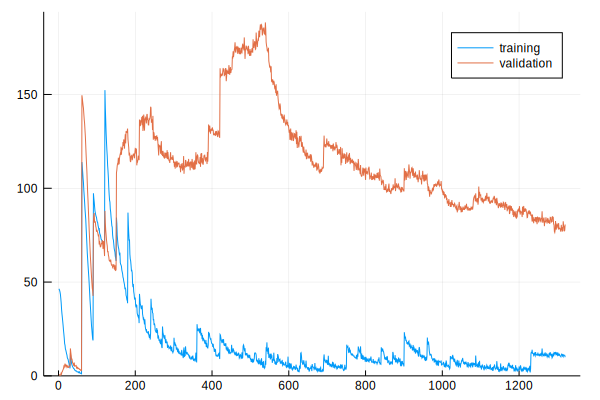

 45.746445 seconds (131.75 M allocations: 15.428 GiB, 11.01% gc time)


Progress:  22%|█████████                                |  ETA: 11:59:11

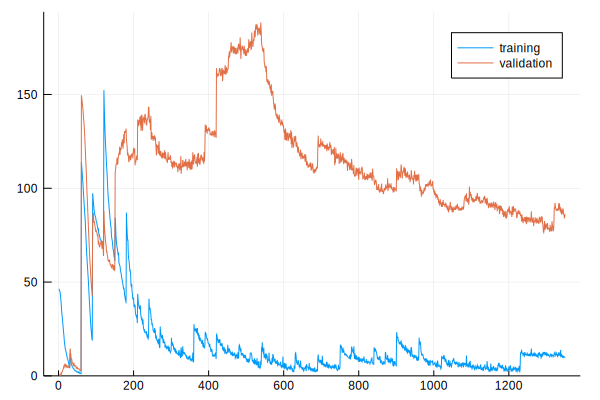

 49.798396 seconds (135.00 M allocations: 15.811 GiB, 14.19% gc time)


Progress:  22%|█████████                                |  ETA: 11:58:58

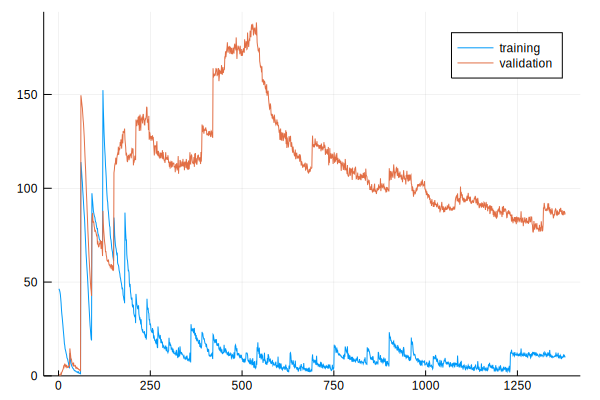

 48.678251 seconds (137.75 M allocations: 16.137 GiB, 12.88% gc time)


Progress:  23%|█████████                                |  ETA: 11:56:29

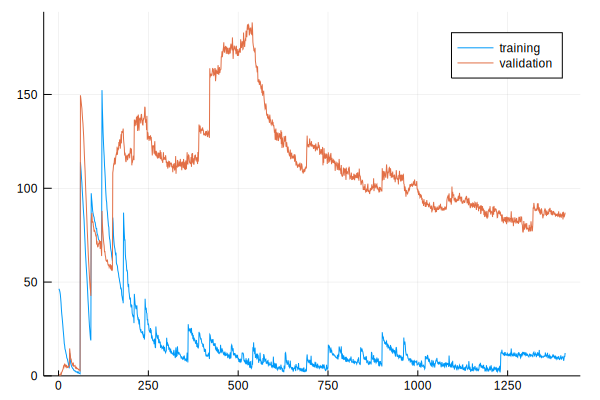

 48.301471 seconds (141.12 M allocations: 16.534 GiB, 11.14% gc time)


Progress:  24%|██████████                               |  ETA: 11:56:07

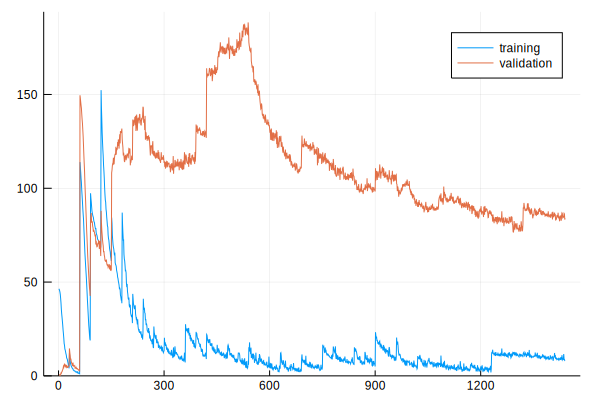

 51.927598 seconds (142.99 M allocations: 16.753 GiB, 14.08% gc time)


Progress:  24%|██████████                               |  ETA: 11:47:30

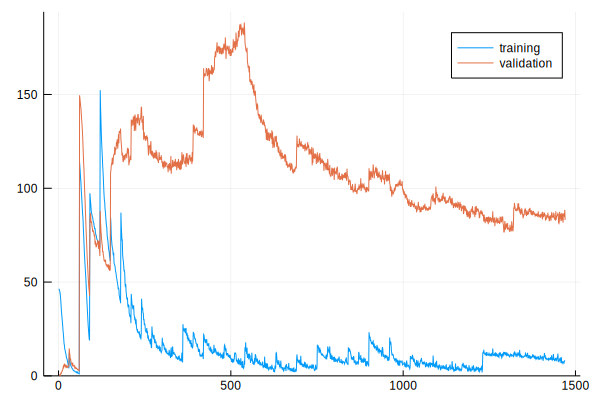

 49.646249 seconds (144.82 M allocations: 16.972 GiB, 10.81% gc time)


Progress:  24%|██████████                               |  ETA: 11:40:57

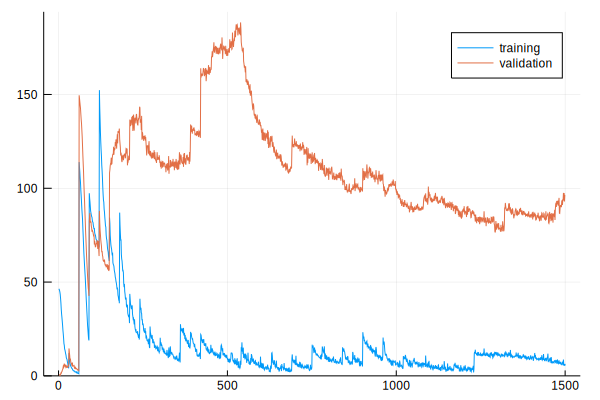

 50.108555 seconds (146.95 M allocations: 17.221 GiB, 10.70% gc time)


Progress:  25%|██████████                               |  ETA: 11:33:37

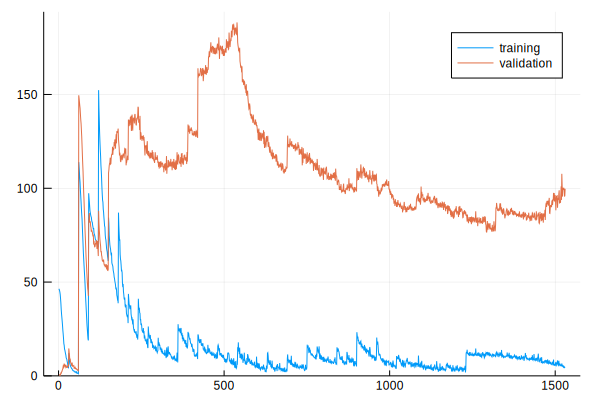

 50.413107 seconds (149.87 M allocations: 17.560 GiB, 9.85% gc time)


Progress:  26%|██████████                               |  ETA: 11:28:44

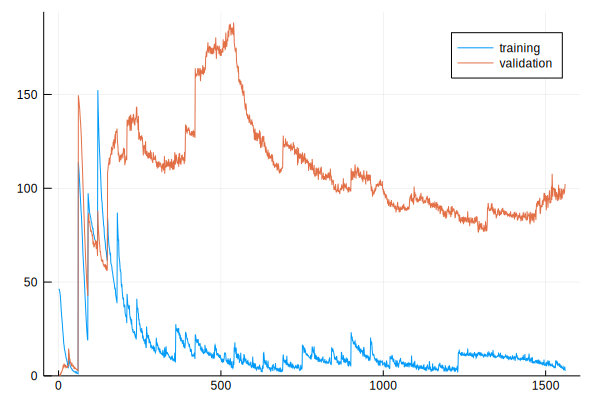

 51.773708 seconds (152.24 M allocations: 17.842 GiB, 10.17% gc time)


Progress:  26%|███████████                              |  ETA: 11:25:16

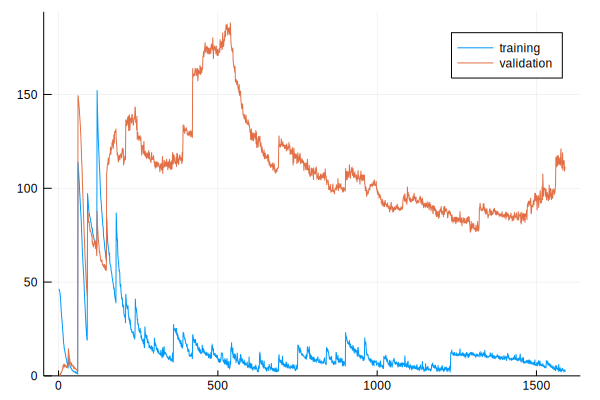

 56.439597 seconds (155.06 M allocations: 18.170 GiB, 13.20% gc time)


Progress:  26%|███████████                              |  ETA: 11:20:04

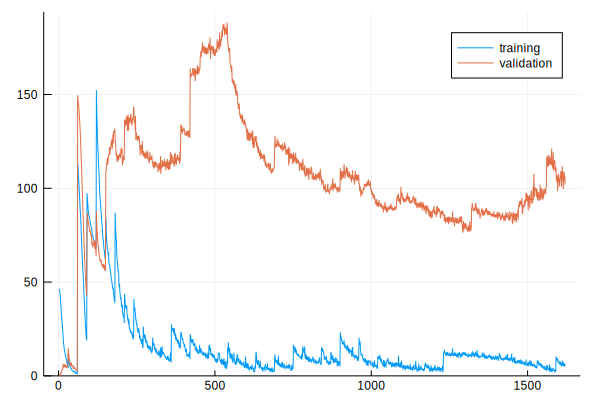

 53.986965 seconds (158.31 M allocations: 18.551 GiB, 10.94% gc time)


Progress:  27%|███████████                              |  ETA: 11:18:00

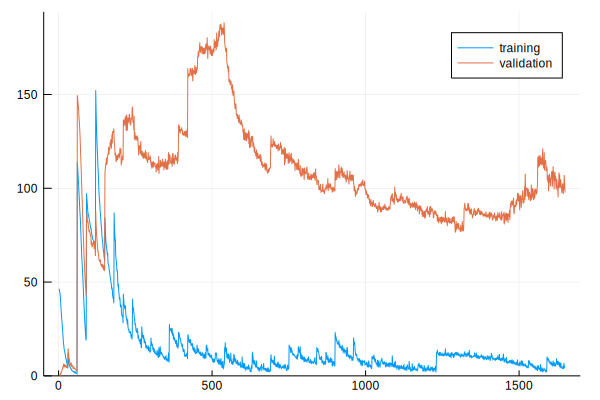

 55.618283 seconds (162.74 M allocations: 19.069 GiB, 10.65% gc time)


Progress:  28%|███████████                              |  ETA: 11:19:32

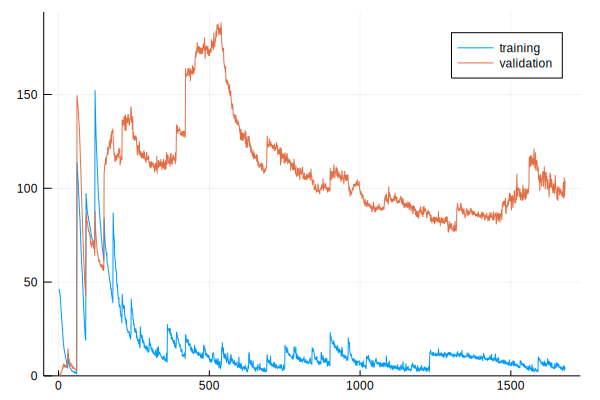

 55.781310 seconds (165.28 M allocations: 19.364 GiB, 10.35% gc time)


Progress:  28%|███████████                              |  ETA: 11:13:26

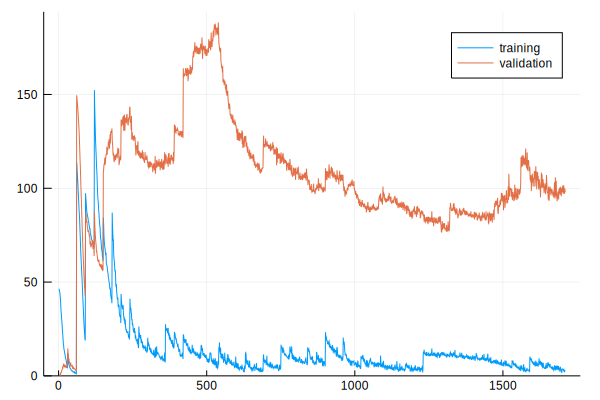

 57.991099 seconds (167.83 M allocations: 19.667 GiB, 10.66% gc time)


Progress:  28%|████████████                             |  ETA: 11:10:23

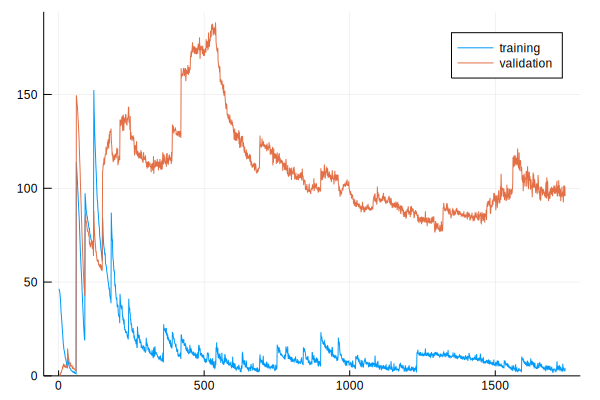

 62.758448 seconds (171.43 M allocations: 20.091 GiB, 14.47% gc time)


Progress:  29%|████████████                             |  ETA: 11:10:01

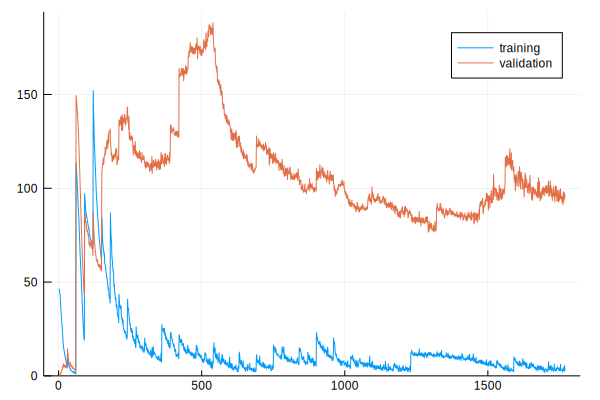

 62.263008 seconds (175.06 M allocations: 20.518 GiB, 13.16% gc time)


Progress:  30%|████████████                             |  ETA: 11:09:48

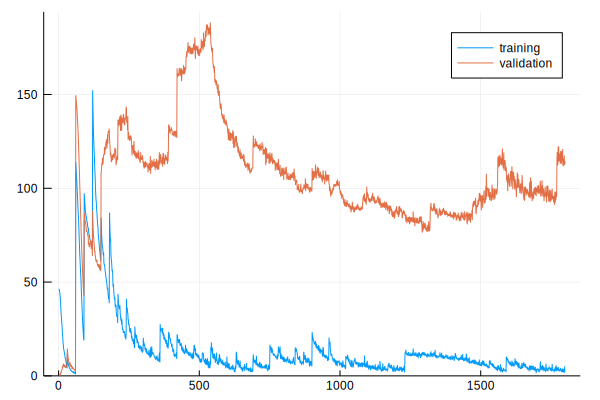

 61.243384 seconds (176.95 M allocations: 20.742 GiB, 11.16% gc time)


Progress:  30%|████████████                             |  ETA: 11:03:53

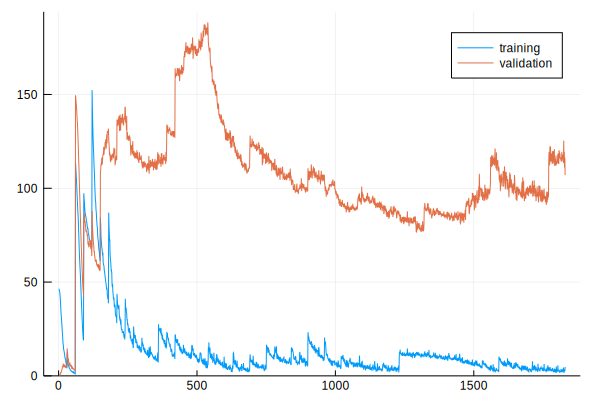

 61.678046 seconds (179.73 M allocations: 21.069 GiB, 10.92% gc time)


Progress:  30%|█████████████                            |  ETA: 11:00:06

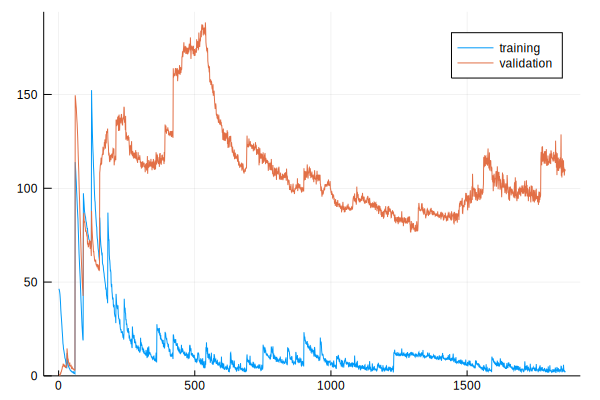

 62.033947 seconds (181.29 M allocations: 21.253 GiB, 10.60% gc time)


Progress:  31%|█████████████                            |  ETA: 10:52:27

In [ ]:
library_file = "library.jld2"
dataset_file = "boxatlas-regularized.jld2"

if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;

datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 200
σv = 2.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, σv * sqrt(i / N_iter))
    end
    collect_into!(dataset.validation_data, σv * sqrt(i / N_iter))
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    filter!(dataset.validation_data) do sample
        all(isfinite, sample.input)
    end
    
    append!(all_training_data, tuple.(dataset.training_data))
    append!(all_validation_data, tuple.(dataset.validation_data))
    push!(all_training_data,
        (LearningMPC.Sample{22, 11, Float64}(
            lqrsol.x0,
            lqrsol.u0,
            lqrsol.x0,
            lqrsol.u0,
            LearningMPC.WarmstartCostRecord{Float64}(Nullable{Float64}(), Nullable{Float64}()),
            LearningMPC.MIPResults(solvetime_s=NaN, objective_bound=0.0, objective_value=0.0)
        ),))

    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
    jldopen(library_file, "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end